 # <font color = #254117>[EEP 147]: ESG Analysis Notebook</font>

 <div style="width:image width px; font-size:80%; text-align:center;"><img src="big_creek.jpg" alt="alternate text" width="500" height="height" style="padding-bottom:0.5em;" />
<br>Big Creek Hydroelectric Project - Southern California Edison</div>

<br>
<font color = "red">Version 2024.2</font>

# Navigating this notebook

- This notebook can be utilized for analysis of the Electricity Strategy Game.
- Open the table of contents: View > Left Sidebar > Show Table of Contents.
- You can click Run > Run All Cells, then scroll to the bottom to use the interface to test adjustments to the demand and carbon prices.
- You can collapse all cells by clicking View > Collapse All Code. We suggest you start by looking at the notebook this way and expanding the sections as necessary.


# 1. Import packages we use
First on our agenda is to import **<font color = ##008700>dependencies</font>** -- packages in Python that add to the basic functions in Python.

In [195]:
from datascience import *
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import numpy as np
import pandas as pd
from ipywidgets import interact, interactive, Dropdown, IntSlider, BoundedFloatText, HTML
import ipywidgets as widgets
from functools import partial
from IPython.display import display
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [10,6]
# Show all columns and rows of pandas DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# 2. Global Variables
Define variables that will be used throughout the notebook.

The variable `current_period` should contain the current round.

The variable `pab_periods` should contain each of the periods for which there was or will be a pay-as-bid auction.  This shouldn't change.

The variable `sections` is the list of section codes and should not be changed.

In [196]:
CURRENT_PERIOD = 0
PAB_PERIODS = [1]
SECTIONS = ['W9','T1','T2']

# 3. Load demand, bids, and portfolio information
Next we load the files for Demand (realized and forecasted), Bids, Porfolios, and the Auction results into pandas dataframes.

In [197]:
# Load the marginal cost bids and the ESG portfolios
BIDS_MC = pd.read_csv('Bids/MC_bids.csv').sort_values('PORTFOLIO')
ESG = pd.read_csv('ESGPorfolios.csv')
# Load the projected demand for each hour of each round/period
DEMAND = pd.read_csv('demand_proj.csv')
# We need to update the demand dataframe with the realized demand from the previous periods
# Note that if the current period is 0, this for loop is not executed and we only use the projected demand
for period_i in range(CURRENT_PERIOD):
    demand_real = pd.read_csv('demand.csv')
    DEMAND.loc[DEMAND["round"] == period_i] = demand_real.loc[demand_real["round"] == period_i].values
# Load the auction results if we've done the auction
if Path('auction_results.csv').exists():
    AUCTION_RESULTS = pd.read_csv('auction_results.csv')

## 3.1 Examine the portfolios of plants
Display the table of plants for a particular portfolio, which shows the costs, carbon intensity, and capacity of each plant.

`Var_Cost_USDperMWH` is the marginal cost of producing one additional MWh.

In [198]:
portfolios = ['Big Coal', 'Big Gas', 'Bay Views', 'Beachfront', 'East Bay', 'Old Timers', 'Fossil Light']
portfolio_to_examine = 'Big Coal'
display(ESG[ESG['Group'] == portfolio_to_examine])

,Group,Group_num,UNIT NAME,Capacity_MW,Fuel_Cost_USDperMWH,Var_OandM_USDperMWH,Var_Cost_USDperMWH,Carbon_tonsperMWH,FixedCst_OandM_perDay,Plant_ID
0,Big Coal,1,FOUR CORNERS,1900,35.00,1.5,36.50,1.10,8000,11
1,Big Coal,1,ALAMITOS 7,250,72.22,1.5,73.72,0.85,0,12
2,Big Coal,1,HUNTINGTON BEACH 1&2,300,39.00,1.5,40.50,0.46,2000,13
3,Big Coal,1,HUNTINGTON BEACH 5,150,65.00,1.5,66.50,0.77,2000,14
4,Big Coal,1,REDONDO 5&6,350,40.44,1.5,41.94,0.48,3000,15
5,Big Coal,1,REDONDO 7&8,950,40.44,1.5,41.94,0.48,5000,16


## 3.2 Join Marginal costs, actual bids, and plant details
Next, we define a function to join the marginal-cost bids dataframe with any updated bids of completed rounds and the ESG plant details. We join based on the column `Plant_ID`. This function is used later in other helper functions.

In [199]:
# Define columns to use from the bid files (sometimes extra columns are present, so we need to specify which ones to use)
BIDS_COLS = ['TEAM', 'TEAM_ID', 'PORTFOLIO', 'PORTFOLIO_ID', 'PLANT', 'PLANT_ID', 'PERIOD', 'PRICE1', 'PRICE2', 'PRICE3', 'PRICE4']

def get_bids(section):
    """
    Retrieves bids data for a given section. 
    Merges the marginal cost bids with the actual bids for the given section's previous rounds.
    Then joins on the ESG data to get the plant information.

    Parameters:
    section (str): The section for which bids data is retrieved. Valid inputs are strings from the `sections` list.

    Returns:
    joined (dataframe): A dataframe containing the bids and plant information for the given section.
    """
    # Verify that section and current period are valid
    assert section in SECTIONS, "Invalid section"
    assert 0 <= CURRENT_PERIOD <= 7, "Invalid current period"

    # Copy the marginal cost bids, to update them with the actual bids for this period
    bids_all = BIDS_MC.copy().sort_values(['PLANT_ID', 'PERIOD'])

    # If current period is 0, there have not been any actual bids yet, so we can simply join on the ESG data and return
    if CURRENT_PERIOD == 0:
        return bids_all.merge(ESG, left_on="PLANT_ID", right_on='Plant_ID', how="left")

    # Load and concatenate the bid files for the completed rounds
    completed_round_filepaths = [f'Bids/{section}_bids_{period_i}.csv' for period_i in range(0,CURRENT_PERIOD)]
    completed_round_dfs = [pd.read_csv(filepath, usecols=BIDS_COLS) for filepath in completed_round_filepaths]
    bids_actual = pd.concat(completed_round_dfs).sort_values(['PLANT_ID', 'PERIOD'])

    # Update the hour1-hour4 price bids in the bids_all dataframe with the actual bids
    periods_to_update = bids_actual.PERIOD.unique()
    # Because bids_all and bids_actual are both sorted by PLANT_ID and PERIOD, we can simply update the rows in bids_all with the rows in bids_actual
    bids_all.loc[bids_all["PERIOD"].isin(periods_to_update)] = bids_actual.values
    
    # Join on the ESG data to get the plant information
    joined = bids_all.merge(ESG, left_on="PLANT_ID", right_on='Plant_ID', how="left")
    return joined

# 4. Define helper functions

## 4.1 Fetch Demand
We will need to load demand for a given hour and period. Let's create a function that looks up the forecasted demand for a period and hour (or the realized demand if in the past). Demand is not certian, so let's also build in some functionality to allow the user to scale demand or replace demand with a different number.

In [200]:
# Show the demand table for the first round (4 hours)
display(DEMAND.head(4))
print(f'Demand for round 0, hour 1: {DEMAND[(DEMAND["round"] == 0) & (DEMAND["hour"] == 1)]["load"][0]} MWh')

,round,hour,load
0,0,1,13200
1,0,2,16000
2,0,3,18000
3,0,4,14000


Demand for round 0, hour 1: 13200 MWh


In [201]:
def demand_calc(hour, period, demand_sp):
    """Load demand and modify it by the demand_sp parameter. 

    Parameters:
    hour (int): The hour of the day (1-4).
    period (int): The period of the game (0-7).
    demand_sp (float): The demand adjustment, which can be a percentage change or a new demand value.
        If demand_sp is between -1 and 1, it is interpreted as a percentage change in demand. 
        If demand_sp is outside of this range, it is interpreted as the new demand value.

    Returns:
    demand (float): The modified demand for the given hour and period.
    """
    # Get the quantity demanded for this period and hour
    demand = DEMAND[(DEMAND["round"] == period) & (DEMAND["hour"] == hour)]["load"].values[0]
    # Adjust the demand by the demand_sp parameter, defined in Variable Definitions section below
    if -1 <= demand_sp <= 1:
        demand *= (1 + demand_sp)
    elif demand_sp > 1:
        demand = demand_sp
    else:
        raise ValueError("Invalid demand_sp value. Must be between -1 and 1 for percentage change, or >1 for new demand value.")
    return(demand)

## 4.2 Calculate price
Once we have the price bids for all plants and the demand in a period and hour, we can calculate the market clearing price. Below is a function to order the bids from low to high and find the market price where generation capacity equals the demand.

In [202]:
def price_calc(bids, demand, hour, period):
    """Calculate the price for a given level of demand, hour, and period, based on the price bids in the bids dataframe.

    Parameters:
    bids (dataframe): A dataframe containing the bids for each plant, for each period and hour.
    demand (float): The quantity of energy demanded.
    hour (int): The hour of the day (1-4).
    period (int): The period of the game (0-7).

    Returns:
    price (float): The price that clears the market for the given demand, hour, and period.
    """
    # Subset the input_df to only include the specified period, and sort the rows by the price
    sorted_bids = (
        # need to make a copy to avoid modifying the original dataframe
        bids.copy()
        # subset to only include the specified period
        .loc[bids["PERIOD"] == period]
        # sort the rows by the price bids for the specified hour, so smallest bid is first
        .sort_values(f"PRICE{hour}", ascending=True)
    )

    # Add a column to keep track of the cumulative capacity, which is the sum of the capacities of the plants up to that row
    sorted_bids['cumulative_capacity'] = sorted_bids['Capacity_MW'].cumsum()

    # Becuase this is sorted, we can simply take the cumulative sum of the Capacity_MW column
    # and find the first row where the cumulative capacity is greater than or equal to the demand
    # Then we return the price from that row
    price = sorted_bids.loc[sorted_bids['cumulative_capacity'] >= demand][f"PRICE{hour}"].values[0]

    return price

## 4.3 Plotting Helper Functions
We define some functions below that will help us plot the bid curves later.

In [203]:
def find_x_pos(widths):
    """Calculate the x positions on a plot for an array of widths.

    Parameters:
    widths (list): A list of widths of bars being plotted.

    Returns:
    list: A list of x positions where the bars will be positioned on the plot.
    """
    cumulative_widths = [0] + widths.cumsum().tolist()
    half_widths = [i/2 for i in widths]
    x_positions = []
    for i in range(len(widths)):
        x_positions.append(half_widths[i] + cumulative_widths[i])
    return x_positions


def price_line_plot(price):
    """Create a horizontal line on the current plot at the specified price."""
    plt.axhline(y=price, color='r', linewidth = 2)
    

def demand_plot(demand):
    """Create a vertical line on the current plot at the specified demand."""
    plt.axvline(x=demand, color='r', linewidth = 2)

## 4.4 Adjusting Marginal Costs and Bids
Define a function to apply a carbon tax and adjust the marginal cost of each plant based on it's carbon intensity.

Define a function to update the bids dataframe with alternative bids (used in a later section).

In [204]:
def adjust_by_cp(bids, hour, period, carbon_price):
    """
    Adjusts the bids dataframe by adding the carbon price to the variable cost and price columns.

    Parameters:
    bids (DataFrame): The input table to be adjusted.
    hour (int): The hour of the adjustment.
    period (int): The period of the adjustment.
    carbon_price (float): The carbon price to be applied to carbon intensity. Units are USD per ton of carbon.

    Returns:
    DataFrame: The adjusted table with the carbon price added to the variable cost and price columns.
    """
    bids_updated = bids.copy()
    # Add the marginal carbon tax burden to the variable cost
    bids_updated["Var_Cost_USDperMWH"] += carbon_price * bids_updated["Carbon_tonsperMWH"]
    # If adding to a future period, update the price bid (which is initially set at marginal cost for future periods)
    if (period >= CURRENT_PERIOD) | (CURRENT_PERIOD == 8):
        bids_updated["PRICE" + str(hour)] += carbon_price * bids_updated["Carbon_tonsperMWH"]
    return bids_updated
    

def user_defined_bids(bids, hour, period, my_portfolio, update_my_bids, update_others_bids, alternative_bids):
    """
    Updates the 'PRICE' column of the bids dataframe based on the specified bidding strategy.

    Args:
        bids (dataframe): The input table containing the data.
        hour (int): The hour for which the bids are being updated.
        period (int): The period for which the bids are being updated.
        my_portfolio (str): The name of the portfolio for which the bids are being updated.
        update_my_bids (bool or str): The bidding strategy for the 'my_portfolio' group. 
            If True, the bids are updated based on the values in the 'bids_myportfolio' dictionary.
            If 'MC', the bids are updated based on the 'Var_Cost_USDperMWH' column of the bids dataframe.
        update_others_bids (bool or str): The bidding strategy for the other groups. 
            If True, the bids are updated based on the values in the respective 'bids_group' dictionaries.
            If 'MC', the bids are updated based on the 'Var_Cost_USDperMWH' column of the bids dataframe.
        alternative_bids (dataframe): A dataframe containing alternative bids for the 'my_portfolio' group. See the example below for the required format.

    Returns:
        dataframe: The updated dataframe with the 'PRICE' column modified based on the specified bidding strategy.
    """
    # Make a local copy of the bids to be updated, and set the index to 'PLANT_ID' for updating the prices
    bids_updated = bids.copy().set_index('UNIT NAME')
    # Filters
    period_filter = bids_updated["PERIOD"] == period
    myportfolio_filter = bids_updated["Group"] == my_portfolio
    not_myportfolio_filter = bids_updated["Group"] != my_portfolio
    
    # Update the price column based on the specified bidding strategy
    if update_my_bids is True:
        # Get the subset of the alternative bids dataframe for the 'my_portfolio' group, set the index to 'PLANT_ID' for updating the prices
        my_bids = alternative_bids[alternative_bids["Group"] == my_portfolio].copy().set_index('UNIT NAME')
        # Update this hour's price column for the 'my_portfolio' group
        bids_updated.update(my_bids[f'PRICE{hour}'])
    
    elif update_my_bids == 'MC':
        # Update this hour's price column for the 'my_portfolio' group based on the marginal costs
        bids_updated.loc[period_filter & myportfolio_filter, f"PRICE{hour}"] = bids_updated.loc[period_filter & myportfolio_filter, 'Var_Cost_USDperMWH']
    
    if update_others_bids is True:
        # Get the subset of the alternative bids dataframe for all non-'my_portfolio' groups, set the index to 'PLANT_ID' for updating the prices
        other_bids = alternative_bids[alternative_bids["Group"] != my_portfolio].copy().set_index('UNIT NAME')
        # Update this hour's price column for all non-'my_portfolio' groups
        bids_updated.update(other_bids[f'PRICE{hour}'])
                
    elif update_others_bids == 'MC':
        # Update this hour's price column for all non-'my_portfolio' groups based on the marginal costs
        bids_updated.loc[period_filter & not_myportfolio_filter, f"PRICE{hour}"] = bids_updated.loc[period_filter & not_myportfolio_filter, 'Var_Cost_USDperMWH']
    
    return bids_updated.reset_index()

## 4.5 Profits
Define a function to calculate the profits of a portfolio of plants based on the market clearing price. The first function calculates profits if we are in a uniform price market. The second function returns profits if we are in a pay-as-you-bid market.

**Uniform-Price Auction**<br>
If the market operates with a uniform-price auction, then all the plants with bids at or below the market clearing price are paid the market clearing price.

**Pay-As-Bid Auction**<br>
If the market operates with a PAB auction, then each plant with a bid at or below the market clearing price are *paid the price they bid*.

**Marginal Capacity**<br>
The total capacity available at exactly the market clearing price. 
For example, if the market clearing price is $40/MWh, the total capacity that was bid *at or under* $40 is 45,000 MW, 
and total capacity that was bid *under* $40 is 40,000 MW, then the marginal capacity (capacity offered at exactly $40/MWh)
is 5,000 MW.

**Marginal Demand**<br>
The amound of demand left over after all the non-marginal capacity has been supplied.
For example, if the market clearing price is $40, the total demand is 40,000 MW, and the sum of all capacity bid at prices less than $40 is 35,000 MW, 
then the marginal demand is 5,000 MW. There must be offered capacity at $40 that is 5,000 MW or greater.


In [205]:
def profit_calc(bids_period, hour, period, demand, price, my_portfolio):
    """Return the profit for a given portfolio, based on the demand and bids for a given period, hour.
    
    Parameters:
    bids_period (DataFrame): The dataframe containing the bids for the selected period.
    hour (int): The hour for which the profit is being calculated.
    period (int): The period for which the profit is being calculated. 
        The period is used to determine if the auction is a Pay-As-Bid or Uniform Price auction.
    demand (float): The quantity of energy demanded for the given hour and period.
    price (float): The price that clears the market for the given demand, hour, and period.
    my_portfolio (str): The name of the portfolio for which the profit is being calculated.

    Returns:
    profit (float): The profit for the given portfolio.
    """
    bids = bids_period.copy()
    
    # Calculate the proportion of the market's marginal capacity avaialable that satisfies marginal demand.
    nonmarginal_capacity = bids.loc[bids[f"PRICE{hour}"] < price, "Capacity_MW"].sum()
    marginal_capacity = bids.loc[bids[f"PRICE{hour}"] == price, "Capacity_MW"].sum()
    marginal_demand = demand - nonmarginal_capacity
    marginal_proportion = marginal_demand / marginal_capacity

    # Find my plants with bids below the market clearing price
    my_bids = bids[bids["Group"] == my_portfolio]
    nonmarginal = my_bids.loc[my_bids[f"PRICE{hour}"] < price]
    # Find my plants with bids at the market clearing price
    marginal = my_bids.loc[my_bids[f"PRICE{hour}"] == price]

    # Calculate the costs of operating my plants this round
    # Calculate the costs for the plants with bids below the market clearing price
    cost = (nonmarginal.Var_Cost_USDperMWH * nonmarginal.Capacity_MW).sum()
    # Add the costs for the plants with bids at the market clearing price, 
    # adjusted by the proportion of their total capacity that was used to satisfy demand
    cost += (marginal.Var_Cost_USDperMWH * marginal.Capacity_MW * marginal_proportion).sum()
    
    # Calculate the revenue for my portfolio, where the marginal capacity is adjusted by the proportion of the marginal demand
    if period in PAB_PERIODS:
        # Calculate the revenue in the Pay-As-Bid auction for an operating plant
        # Calculate the revenue for the plants with bids below the market clearing price
        revenue = (nonmarginal[f"PRICE{hour}"] * nonmarginal.Capacity_MW).sum()
        # Add the revenue for the plants with bids at the market clearing price,
        revenue += (marginal[f"PRICE{hour}"] * marginal.Capacity_MW * marginal_proportion).sum()
    else:
        # Calculate the revenue in the Uniform Price auction for an operating plant
        # Calculate the revenue for the plants with bids below the market clearing price
        revenue = (price * nonmarginal.Capacity_MW).sum()
        # Add the revenue for the plants with bids at the market clearing price,
        revenue += (price * marginal.Capacity_MW * marginal_proportion).sum()

    # Calculate the profit
    profit = revenue - cost
    return profit

In [206]:
def total_profits(section, my_portfolio, carbon_price_vec):
    # Merge auction results with input table
    portfolio_profit_dict = {}
    #auction_results_section = auction_results.where("world_id", section)
    if CURRENT_PERIOD > 1:
        joined_table = get_bids(section)
    #    full_table = joined_table.join("TEAM", auction_results_section, "team")
        portfolio_table = full_table.where("Group", my_portfolio)
        portfolio_profit = -portfolio_table.where("PERIOD", 1).to_df().loc[0, "adjustment"] * 1.05**(CURRENT_PERIOD-2)
        for period_i in range(1, CURRENT_PERIOD):        
            portfolio_table_period = joined_table.where("PERIOD", period_i).where("Group", my_portfolio)
            portfolio_profit_period = -sum(portfolio_table_period["FixedCst_OandM_perRound"])
            
            carbon_price = carbon_price_vec[period_i - 1]
            
            for hour_i in range(1, 5):
                demand = demand_calc(hour_i, period_i, 0)
                joined_table = adjust_by_cp(joined_table, hour_i, period_i, carbon_price)
                sorted_joined_table = joined_table.where("PERIOD", period_i).sort("PRICE" + str(hour_i), descending = False)
                price = price_calc(sorted_joined_table, demand, hour_i, period_i)
                
                portfolio_profit_period += profit_calc(sorted_joined_table, hour_i, period_i, demand, price, my_portfolio)
                portfolio_profit_dict['Round ' + str(period_i)] = portfolio_profit_period
                    
            portfolio_profit += portfolio_profit_period * 1.05**(CURRENT_PERIOD - period_i - 1)
    else: 
        portfolio_profit = 0
    portfolio_profit_dict['Total'] = portfolio_profit
    
    output_df = pd.DataFrame.from_dict(portfolio_profit_dict, 
                                       orient = 'index', columns = [my_portfolio + ' Profit']).round().astype(int)
    
    return output_df

## 4.6 Emissions
Calculate total emissions for all *operating* plants in a group.

In [207]:
def emissions_calc(bids_period, hour, period, demand, price, my_portfolio):    
    bids = bids_period.copy()
    
    # Calculate the marginal capacity and demand
    nonmarg_capacity = bids.loc[bids[f"PRICE{hour}"] < price, "Capacity_MW"].sum()
    marg_capacity = bids.loc[bids[f"PRICE{hour}"] == price, "Capacity_MW"].sum()
    marg_demand = demand - nonmarg_capacity
    marg_proportion = marg_demand / marg_capacity
    
    # Calculate the emissions, where the marginal capacity is adjusted by the proportion of the marginal demand
    my_bids = bids[bids["Group"] == my_portfolio]
    emissions = 0
    for _, row in my_bids.loc[my_bids[f"PRICE{hour}"] < price].iterrows():
        emissions += row["Carbon_tonsperMWH"] * row["Capacity_MW"]
    for _, row in my_bids.loc[my_bids[f"PRICE{hour}"] == price].iterrows():
        emissions += row["Carbon_tonsperMWH"] * row["Capacity_MW"] * marg_proportion
    return emissions

In [208]:
def total_emissions(section, my_portfolio):
    portfolio_emissions_dict = {}
    if CURRENT_PERIOD > 1:
        joined_table = get_bids(section)
        portfolio_emissions = 0
        for period_i in range(1, CURRENT_PERIOD):        
            portfolio_emissions_period = 0
            
            for hour_i in range(1, 5):
                demand = demand_calc(hour_i, period_i, 0)
                sorted_joined_table = joined_table.where("PERIOD", period_i).sort("PRICE" + str(hour_i), descending = False)
                price = price_calc(sorted_joined_table, demand, hour_i, period_i)
                
                portfolio_emissions_period += emissions_calc(sorted_joined_table, hour_i, period_i, demand, price, my_portfolio)
                portfolio_emissions_dict['Round ' + str(period_i)] = portfolio_emissions_period
                    
            portfolio_emissions += portfolio_emissions_period
    else: 
        portfolio_emissions = 0
    portfolio_emissions_dict['Total'] = portfolio_emissions
    
    output_df = pd.DataFrame.from_dict(portfolio_emissions_dict, 
                                       orient = 'index', columns = [my_portfolio + ' Emissions']).round().astype(int)
    
    return output_df

## 5 Plotting the Market and Portfolio

## 5.1 Plotting Functions

In [209]:
ENERGY_COLORS_DICT = {'Bay Views' : '#EC5F67', 'Beachfront' : '#F29056', 'Big Coal' : '#F9C863', 'Big Gas' : '#99C794', 
                      'East Bay' : '#5FB3B3', 'Fossil Light' : '#6699CC', 'Old Timers' : '#C594C5'}

In [210]:
def market_plot(bids_period, hour, period, demand, price):
    bids = bids_period.copy()
    
    width = bids["Capacity_MW"]
    height = bids[f"PRICE{hour}"]
    x_vals = find_x_pos(width)
    colors_mapped = bids['Group'].map(ENERGY_COLORS_DICT).to_list()
    # Temporary fix: convert the bids dataframe to a datasceince Table
    bids = Table.from_df(bids)
    bids = bids.with_column('Color', colors_mapped)
    group_colors = bids.group("Group", lambda x: x).select("Group", "Color")
    group_colors["Color"] = group_colors.apply(lambda x: x[0], "Color")
    
    #prepare the Marginal Cost to be a dashed line
    num_plants = len(width)
    height_mc = bids["Var_Cost_USDperMWH"]
    x_vec = np.zeros(num_plants * 2)
    h_vec = np.zeros(num_plants * 2)
    for i, (w, h) in enumerate(zip(width, height_mc)):
        h_vec[2*i] = h
        h_vec[2*i+1] = h
        if i == 0:
            x_vec[1] = w
        else: 
            x_vec[2*i] = x_vec[2*i - 1]
            x_vec[2*i + 1] = x_vec[2*i] + w
            
    # Make the plot
    plt.figure(figsize=(9,6))
    plt.bar(x_vals, height, width=width, color=bids['Color'], edgecolor = "black")
    plt.bar(x_vals, height_mc, width=width, color=bids['Color'], edgecolor = "black", alpha=.2)
    line_mc = plt.plot(x_vec, h_vec, '--k', label='Marginal Cost', linewidth=2)
    patches = []
    for row in group_colors.rows:
        patches += [mpatches.Patch(color=row.item("Color"), label=row.item("Group"))]    
    patches += line_mc
    plt.legend(handles=patches, bbox_to_anchor=(1.1,1))
    plt.title('Energy Market')
    plt.xlabel('Capacity_MW')
    plt.ylabel('Price')
    #plt.ylim((0,200))
    price_line_plot(price)
    demand_plot(demand)
    plt.show()

In [211]:
def portfolio_plot(bids, hour, period, demand, price, my_portfolio):    
    sorted_joined_table = Table.from_df(bids.copy())
    
    your_source = sorted_joined_table.where("Group", my_portfolio)
    width_yours = your_source.column("Capacity_MW")
    height_yours = your_source.column(f"PRICE{hour}")
    new_x_yours = find_x_pos(width_yours)
    label_yours = your_source.column("PLANT")
    colors_mapped = list(pd.Series(sorted_joined_table['Group']).map(ENERGY_COLORS_DICT))
    sorted_joined_table = sorted_joined_table.with_column('Color', colors_mapped)
    group_colors = sorted_joined_table.group("Group", lambda x: x).select("Group", "Color")
    group_colors["Color"] = group_colors.apply(lambda x: x[0], "Color")
    
    #prepare the Marginal Cost to be a dashed line
    num_plants = len(width_yours)
    height_mc = your_source.column("Var_Cost_USDperMWH")
    x_vec = np.zeros(num_plants * 2)
    h_vec = np.zeros(num_plants * 2)
    for i, (w, h) in enumerate(zip(width_yours, height_mc)):
        h_vec[2*i] = h
        h_vec[2*i+1] = h
        if i == 0:
            x_vec[1] = w
        else: 
            x_vec[2*i] = x_vec[2*i - 1]
            x_vec[2*i + 1] = x_vec[2*i] + w
            
    # Make the plot
    plt.figure(figsize=(11,6))
    plt.bar(new_x_yours, height_yours, width=width_yours, 
            color = ENERGY_COLORS_DICT[my_portfolio], edgecolor = "black")
    plt.bar(new_x_yours, height_mc, width=width_yours, 
            color = ENERGY_COLORS_DICT[my_portfolio], edgecolor = "black", alpha=.2)
    line_mc = plt.plot(x_vec, h_vec, '--k', label='Marginal Cost', linewidth=2)
    plt.title("Bids: " + my_portfolio)
    plt.xlabel('Capacity_MW')
    plt.ylabel('Price')
    for new_x_i, height_i, label_i in zip(new_x_yours, height_yours, label_yours):
        plt.text(new_x_i, height_i, label_i, ha='center', va='bottom', fontsize=8)
    price_line_plot(price)
            
    #the marginal plants should indicate how much capacity they produce
    nonmarg_capacity = sum(sorted_joined_table.where(f"PRICE{hour}", are.below(price))["Capacity_MW"])
    marg_capacity = sum(sorted_joined_table.where(f"PRICE{hour}", are.equal_to(price))["Capacity_MW"])
    marg_demand = demand - nonmarg_capacity
    marg_proportion = marg_demand / marg_capacity
    
    curr_capacity = 0
    
    for i, (w, h) in enumerate(zip(width_yours, height_yours)):
        if h == price:
            x_val = curr_capacity + (w * marg_proportion)
            x_vec = [x_val, x_val]
            h_vec = [0, h]
            plt.plot(x_vec, h_vec, '--k', linewidth=1)
        elif h > price:
            break
        curr_capacity += w
    
    plt.axvline(x=curr_capacity, color='k', linewidth = 2)
    
    plt.show()

## 5.2 Putting it all together
Demand, Bids, Market Price, Profits, and Emissions

Here is the main wrapper function

In [212]:
def all_output(section, hour, period, my_portfolio, demand_sp, carbon_p4, carbon_p5, carbon_p6, update_my_bids, update_others_bids, alternative_bids):
    print()
    
    # print that the current period is a pay-as-bid auction if it is
    if period in PAB_PERIODS:
        print('\033[1mNote:\033[0;0m The current period is a pay-as-bid auction.')
        print('')
    
    # print demand
    demand = demand_calc(hour, period, demand_sp)
    print("Demand: " + str(round(demand, 2)))
    
    # print price
    bids = get_bids(section)
    carbon_price_vec = [0, 0, 0, carbon_p4, carbon_p5, carbon_p6]
    carbon_price = carbon_price_vec[period - 1]
    bids['Original MC'] = bids['Var_Cost_USDperMWH']
    bids = adjust_by_cp(bids, hour, period, carbon_price)
    bids = user_defined_bids(bids, hour, period, my_portfolio, update_my_bids, update_others_bids, alternative_bids)
    bids_period = bids[bids["PERIOD"] == period].sort_values(f"PRICE{hour}", ascending=True)
    price = price_calc(bids_period, demand, hour, period)
    print("Price: $" + str(round(price, 2)))
    
    # print profits and emissions
    my_profit = profit_calc(bids_period, hour, period, demand, price, my_portfolio)
    print(my_portfolio + ' Profit: $' + str(round(my_profit, 2)))
    my_emissions = emissions_calc(bids_period, hour, period, demand, price, my_portfolio)
    print(my_portfolio + ' Emissions: ' + str(round(my_emissions, 2)) + ' Tons CO2')
    
    # produce plots
    market_plot(bids_period, hour, period, demand, price)
    portfolio_plot(bids_period, hour, period, demand, price, my_portfolio)
    
    # the marginal plants should indicate how much capacity they produce
    nonmarg_capacity = bids_period.loc[bids_period[f"PRICE{hour}"] < price, "Capacity_MW"].sum()
    marg_capacity = bids_period.loc[bids_period[f"PRICE{hour}"] == price, "Capacity_MW"].sum()
    marg_demand = demand - nonmarg_capacity
    marg_proportion = marg_demand / marg_capacity
    
    
    # display information about plants
    display_bids = bids_period[bids_period["Group"] == my_portfolio].copy()
    display_bids.rename(columns = {'PLANT':'Plant', 'Var_Cost_USDperMWH':'Adjusted MC', 'Carbon_tonsperMWH':'Emissions Rate', f"PRICE{hour}":'Bid',
                                  'Capacity_MW':'Capacity'}, inplace = True) 
    display_bids['Output'] = np.where(display_bids['Bid'] < price, display_bids['Capacity'],
                                      np.where(display_bids['Bid'] == price, display_bids['Capacity'] * marg_proportion,
                                               0)).round(1)
    display_bids.set_index(keys = 'Plant', inplace = True)
    display_bids.index.name = None
    print(f'\n\n {my_portfolio} Bids')
    display(display_bids[['Original MC', 'Emissions Rate', 'Adjusted MC', 'Bid', 'Capacity','Output']])

## 5.3 Define the alternative bids for all portfolios

### 5.3.1 Alternative Bids Helper Functions
To help setup a dictionary that can be modified by users, we need to print a base dictionary of all marginal costs.
Print a dictionary of portfolios and their plants/marginal costs -- these can be copied and pasted into the alternative_bids dictionary in the next cell.

In [213]:
# Print dictionary elements for marginal costs of all plants, by portfolio
print('ALTERNATIVE_BIDS = {')
for group in ESG.Group.unique():
    plants = ESG[ESG.Group == group]['UNIT NAME'].tolist()
    li = [f"'{plant}': {ESG.loc[(ESG['Group'] == group) & (ESG['UNIT NAME'] == plant), 'Var_Cost_USDperMWH'].values[0]}" for plant in plants]
    print(f"\t'{group}'" + ": {" + ", ".join(li) + "},")
print('}')

ALTERNATIVE_BIDS = {
	'Big Coal': {'FOUR CORNERS': 36.5, 'ALAMITOS 7': 73.72, 'HUNTINGTON BEACH 1&2': 40.5, 'HUNTINGTON BEACH 5': 66.5, 'REDONDO 5&6': 41.94, 'REDONDO 7&8': 41.94},
	'Big Gas': {'EL SEGUNDO 1&2': 44.83, 'EL SEGUNDO 3&4': 41.22, 'LONG BEACH': 52.5, 'NORTH ISLAND': 65.5, 'ENCINA': 41.67, 'KEARNY': 90.06, 'SOUTH BAY': 43.83},
	'Bay Views': {'MORRO BAY 1&2': 38.78, 'MORRO BAY 3&4': 36.61, 'MOSS LANDING 6': 32.56, 'MOSS LANDING 7': 32.56, 'OAKLAND': 61.17},
	'Beachfront': {'COOLWATER': 42.39, 'ETIWANDA 1-4': 42.67, 'ETIWANDA 5': 62.89, 'ELLWOOD': 75.61, 'MANDALAY 1&2': 39.06, 'MANDALAY 3': 52.06, 'ORMOND BEACH 1': 38.06, 'ORMOND BEACH 2': 38.06},
	'East Bay': {'PITTSBURGH 1-4': 40.94, 'PITTSBURGH 5&6': 36.61, 'PITTSBURGH 7': 59.72, 'CONTRA COSTA 4&5': 58.28, 'CONTRA COSTA 6&7': 39.5, 'POTRERO HILL': 69.83},
	'Old Timers': {'BIG CREEK': 0.0, 'MOHAVE 1': 34.5, 'MOHAVE 2': 34.5, 'HIGHGROVE': 49.61, 'SAN BERNADINO': 53.94},
	'Fossil Light': {'HUMBOLDT': 47.44, 'HELMS': 0.5, 'HUN

To help with merging, we need to convert the dictionary the user edits into a dataframe that can be merged with the bids data.

In [214]:
def convert_dict_to_df(dict1):
    """Convert the alternative bids dictionary to a dataframe for merging, assumging all prices are the same for all hours."""
    # Create a dictionary to hold the columns of the dataframe
    dict2 = {'Group': [], 'UNIT NAME': [], 'PRICE1': [], 'PRICE2': [], 'PRICE3': [], 'PRICE4': []}
    # Iterate through the keys of the input dictionary and add the values to the columns of the new dictionary
    for k1 in dict1.keys():
        for k2 in dict1[k1].keys():
            dict2['Group'].append(k1)
            dict2['UNIT NAME'].append(k2)
            dict2['PRICE1'].append(dict1[k1][k2])
            dict2['PRICE2'].append(dict1[k1][k2])
            dict2['PRICE3'].append(dict1[k1][k2])
            dict2['PRICE4'].append(dict1[k1][k2])

    return pd.DataFrame(dict2)

### 5.3.2 Alternative Bids -- You can adjust these to test scenarios

Now we can define alternative bids to allow us to test difference scenarios -- if we change our bids, how does the bid curve and market clearing price change? What if other teams bid different from their marginal costs?

You can change the prices below to set the bids for your portfolio or other teams' portfolios.

These alternative bids are only used if `update_my_bids` or `update_others_bids` are True in the dropdown menus in the widgets in lower sections.

If you need to reset this section, just copy and paste from the ouptut in section 5.3.1.

In [215]:
ALTERNATIVE_BIDS = {
	'Big Coal': {'FOUR CORNERS': 36.5, 'ALAMITOS 7': 73.72, 'HUNTINGTON BEACH 1&2': 40.5, 'HUNTINGTON BEACH 5': 66.5, 'REDONDO 5&6': 41.94, 'REDONDO 7&8': 41.94},
	'Big Gas': {'EL SEGUNDO 1&2': 44.83, 'EL SEGUNDO 3&4': 41.22, 'LONG BEACH': 52.5, 'NORTH ISLAND': 65.5, 'ENCINA': 41.67, 'KEARNY': 90.06, 'SOUTH BAY': 43.83},
	'Bay Views': {'MORRO BAY 1&2': 38.78, 'MORRO BAY 3&4': 36.61, 'MOSS LANDING 6': 32.56, 'MOSS LANDING 7': 32.56, 'OAKLAND': 61.17},
	'Beachfront': {'COOLWATER': 42.39, 'ETIWANDA 1-4': 42.67, 'ETIWANDA 5': 62.89, 'ELLWOOD': 75.61, 'MANDALAY 1&2': 39.06, 'MANDALAY 3': 52.06, 'ORMOND BEACH 1': 38.06, 'ORMOND BEACH 2': 38.06},
	'East Bay': {'PITTSBURGH 1-4': 40.94, 'PITTSBURGH 5&6': 36.61, 'PITTSBURGH 7': 59.72, 'CONTRA COSTA 4&5': 58.28, 'CONTRA COSTA 6&7': 39.5, 'POTRERO HILL': 69.83},
	'Old Timers': {'BIG CREEK': 0.0, 'MOHAVE 1': 34.5, 'MOHAVE 2': 34.5, 'HIGHGROVE': 49.61, 'SAN BERNADINO': 53.94},
	'Fossil Light': {'HUMBOLDT': 47.44, 'HELMS': 0.5, 'HUNTERS POINT 1&2': 49.17, 'HUNTERS POINT 4': 75.89, 'DIABLO CANYON 1': 11.5},
}

The next cell runs everything.

## 5.4 Variable Definitions for the plotting widget below

`Section`: Section of the ESG game in which you are participating (defined by the table below).

| Code | Section Time  |
|---------|---------------|
| "W9" | Wednesday 9am|
| "T1" | Thursday 4pm - Aaron, Room 130|
| "T2" | Thursday 4pm - Max, Room 220|

`Hour`: Hour within the current round (ranges from 1 to 4).

`Period`: Round number (ranges from 0 to 6).

`my_portfolio`: Team portfolio of interest.

`demand_sp`: Adjustment to forecasted demand (or realized demand in past rounds). If value is between -1 and 1, gives a percentage change from forecasted demand. If value is greater than 1, gives a new value for demand in MWh.
For example, a value of 0.05 will assign demand to be (forecasted demand times 1.05). A value of 15000 will assign demand to be 15,000 MWh.

`carbon_pX`: Assigns a carbon price in period X.
- Changing the carbon price will automatically adjust MC to include the per-unit tax burden, calculated using the carbon intensity of the plant.
- If changed for the current or future period, this will also automatically increase bid prices to inlcude the per-unit tax burden.

`def_my_bids`: If TRUE, then allows you to alter the bids for the portfolio selected in `my_portfolio`. Alteration of bids can occur in the code in block 13 (above). If MC, bids will revert to adjusted MC (this differs from FALSE only for past rounds).

`def_others_bids`: If TRUE, then allows you to alter the bids of the portfolios not selected in `my_portfolio`. Alteration of bids can occur in the code in block 13 (above). If MC, bids will revert to adjusted MC (this differs from FALSE only for past rounds).

## 5.5 Plot the Market and Portfolio

In [216]:
# Inject custom CSS into this cell to allow the full variable names to be displayed next to the dropdowns
custom_css = """<style> .widget-label {min-width: 250px !important;} .widget-dropdown {width: 400px !important;} </style>"""
display(HTML(custom_css))

# Create an interface to allow the user to test adjustments to demand, carbon prices, and bids
interact_obj = interact(lambda section, hour, period, my_portfolio, demand_sp, carbon_p4, carbon_p5, carbon_p6, update_my_bids, update_others_bids:
         all_output(section = section,
                    hour = hour,
                    period = period,
                    my_portfolio = my_portfolio,
                    demand_sp = demand_sp,
                    carbon_p4 = carbon_p4,
                    carbon_p5 = carbon_p5,
                    carbon_p6 = carbon_p6,
                    update_my_bids = update_my_bids,
                    update_others_bids = update_others_bids,
                    alternative_bids=convert_dict_to_df(ALTERNATIVE_BIDS)
         ),
         section = Dropdown(options=SECTIONS),
         hour = Dropdown(options=list(range(1,5))), 
         period = Dropdown(value = min(CURRENT_PERIOD, 6), options=list(range(0,7))),
         my_portfolio = Dropdown(options=np.unique(ESG["Group"])),
         demand_sp = BoundedFloatText(value=0, min = -1, max = np.sum(ESG['Capacity_MW']), step=0.001, layout=widgets.Layout(width='350px')),
         carbon_p4 = BoundedFloatText(value=0, min = 0, max = 300, step=0.01, layout=widgets.Layout(width='350px')),
         carbon_p5 = BoundedFloatText(value=0, min = 0, max = 300, step=0.01, layout=widgets.Layout(width='350px')),
         carbon_p6 = BoundedFloatText(value=0, min = 0, max = 300, step=0.01, layout=widgets.Layout(width='350px')),
         update_my_bids = Dropdown(options=[False, True, 'MC'], description="Update my bids with alternative bids"),
         update_others_bids = Dropdown(options=[False, True, 'MC'], description="Update others' bids with alternative bids"))

HTML(value='<style> .widget-label {min-width: 250px !important;} .widget-dropdown {width: 400px !important;} <…

interactive(children=(Dropdown(description='section', options=('W9', 'T1', 'T2'), value='W9'), Dropdown(descri…


Note: The current period is a pay-as-bid auction.

Demand: 11000
Price: $39.06
Big Coal Profit: $0.0
Big Coal Emissions: 2090.0 Tons CO2


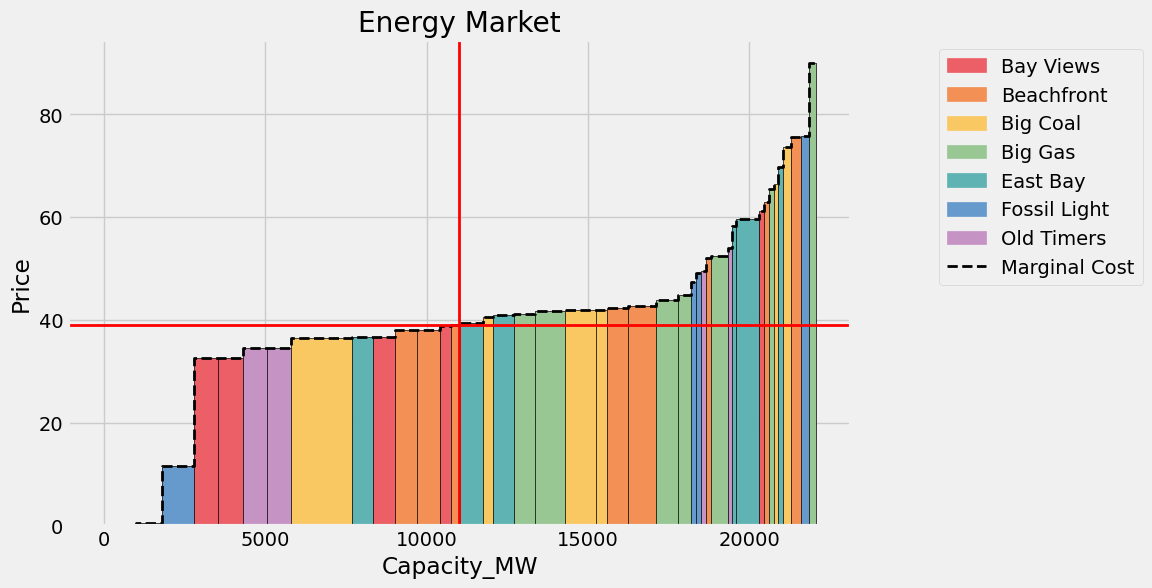

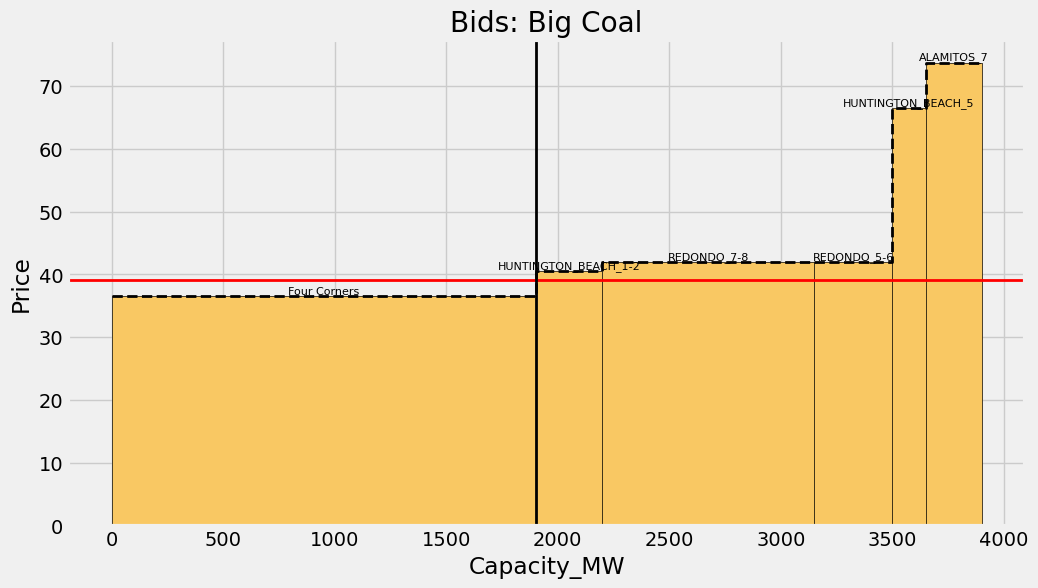



 Big Coal Bids


,Original MC,Emissions Rate,Adjusted MC,Bid,Capacity,Output
Four Corners,36.50,1.10,36.50,36.50,1900,1900.0
HUNTINGTON_BEACH_1-2,40.50,0.46,40.50,40.50,300,0.0
REDONDO_7-8,41.94,0.48,41.94,41.94,950,0.0
REDONDO_5-6,41.94,0.48,41.94,41.94,350,0.0
HUNTINGTON_BEACH_5,66.50,0.77,66.50,66.50,150,0.0
ALAMITOS_7,73.72,0.85,73.72,73.72,250,0.0


In [217]:
interact_obj('W9', 1, 1, 'Big Coal', 0, 0, 0, 0, False, False)

# 6 Carbon Price Forecasting

Finally, let's predict emissions under *competitive* bidding with the given carbon price.

In [218]:
def predicted_emissions_456(section, D_R4_H1, D_R4_H2, D_R4_H3, D_R4_H4, D_R5_H1, D_R5_H2, D_R5_H3, D_R5_H4,
                            D_R6_H1, D_R6_H2, D_R6_H3, D_R6_H4, carbon_p4, carbon_p5, carbon_p6):
    demand_sp_vec = [D_R4_H1, D_R4_H2, D_R4_H3, D_R4_H4, D_R5_H1, D_R5_H2, D_R5_H3, D_R5_H4,
                  D_R6_H1, D_R6_H2, D_R6_H3, D_R6_H4]
    carbon_price_vec = [0, 0, 0, carbon_p4, carbon_p5, carbon_p6]
    emissions_dict = {'Round 4':{}, 'Round 5':{}, 'Round 6':{}, 'Total':{}}
    joined_table = get_bids(section)
    total_emissions = 0
    portfolio_emissions = 0
    for period_i in [4, 5, 6]:  
        total_emissions_period = 0
        carbon_price = carbon_price_vec[period_i - 1]

        for hour_i in [1, 2, 3, 4]:
            if (period_i < CURRENT_PERIOD) & (CURRENT_PERIOD < 8):
                joined_table_adj = user_defined_bids(joined_table, hour_i, period_i, 
                                                 my_portfolio = 'Big Coal', 
                                                 update_my_bids = False, update_others_bids = False)
            else:
                joined_table_adj = adjust_by_cp(joined_table, hour_i, period_i, carbon_price)
            demand_sp = demand_sp_vec[4*(period_i - 4) + (hour_i - 1)]
            demand = demand_calc(hour_i, period_i, demand_sp)
            sorted_joined_table = joined_table_adj[joined_table_adj.PERIOD == period_i].sort_values(f"PRICE{hour_i}", ascending=True)
            price = price_calc(sorted_joined_table, demand, hour_i, period_i)

            for group in np.unique(ESG["Group"]):
                emissions_i = emissions_calc(sorted_joined_table, hour_i, period_i, demand, price, group)
                total_emissions_period += emissions_i
                if group not in emissions_dict['Round ' + str(period_i)].keys(): 
                    emissions_dict['Round ' + str(period_i)][group] = emissions_i
                else:
                    emissions_dict['Round ' + str(period_i)][group] += emissions_i
                if group not in emissions_dict['Total'].keys(): 
                    emissions_dict['Total'][group] = emissions_i
                else:
                    emissions_dict['Total'][group] += emissions_i
        
        emissions_dict[f'Round {period_i}']['Total Emissions'] = total_emissions_period
        total_emissions += total_emissions_period
        
    emissions_dict['Total']['Total Emissions'] = total_emissions
    
    output_df = pd.DataFrame(emissions_dict).round(2)
    
    return(output_df)

In [219]:
#function to get emissions across sections
def predicted_emissions_all_456(D_R4_H1, D_R4_H2, D_R4_H3, D_R4_H4, D_R5_H1, D_R5_H2, D_R5_H3, D_R5_H4,
                                D_R6_H1, D_R6_H2, D_R6_H3, D_R6_H4, carbon_p4, carbon_p5, carbon_p6):
    
    #need two dictionaries: one for the dataframe for all sections, one to store individual section dataframes
    emissions_dict_all = {'Round 4':{}, 'Round 5':{}, 'Round 6':{}, 'Total':{}}
    predicted_emissions_dfs = {}
    for section in SECTIONS:
        predicted_emissions_df = predicted_emissions_456(section = section,
                                                         D_R4_H1 = D_R4_H1,
                                                         D_R4_H2 = D_R4_H2,
                                                         D_R4_H3 = D_R4_H3,
                                                         D_R4_H4 = D_R4_H4,
                                                         D_R5_H1 = D_R5_H1,
                                                         D_R5_H2 = D_R5_H2,
                                                         D_R5_H3 = D_R5_H3,
                                                         D_R5_H4 = D_R5_H4,
                                                         D_R6_H1 = D_R6_H1,
                                                         D_R6_H2 = D_R6_H2,
                                                         D_R6_H3 = D_R6_H3,
                                                         D_R6_H4 = D_R6_H4,
                                                         carbon_p4 = carbon_p4,
                                                         carbon_p5 = carbon_p5,
                                                         carbon_p6 = carbon_p6)
        #add section dataframe to the dfs dictionary
        predicted_emissions_dfs[section] = predicted_emissions_df
        
        #get the emissions from each round by section for the total dataframe
        for period_i in range(4, 7): 
            emissions_dict_all['Round ' + str(period_i)][section] = predicted_emissions_df.loc['Total Emissions',
                                                                                               'Round ' + str(period_i)]
        emissions_dict_all['Total'][section] = predicted_emissions_df.loc['Total Emissions', 'Total']
        
    #create dataframe for all sections
    emissions_df = pd.DataFrame(emissions_dict_all).round(2)
    emissions_df.loc['Total Emissions',:] = emissions_df.sum(axis = 0)
    emissions_df.columns.name = 'All'
    display(emissions_df)
        
    #print individual section dataframes
    for section in SECTIONS:
        print(f'Predicted Emissions for Section {section}:')
        predicted_emissions_df = predicted_emissions_dfs[section]
        predicted_emissions_df.columns.name = section
        display(predicted_emissions_df)

In [220]:
interact(lambda D_R4_H1, D_R4_H2, D_R4_H3, D_R4_H4, D_R5_H1, D_R5_H2, D_R5_H3, D_R5_H4, 
         D_R6_H1, D_R6_H2, D_R6_H3, D_R6_H4, carbon_p4, carbon_p5, carbon_p6:
         predicted_emissions_all_456(D_R4_H1 = D_R4_H1,
                                     D_R4_H2 = D_R4_H2,
                                     D_R4_H3 = D_R4_H3,
                                     D_R4_H4 = D_R4_H4,
                                     D_R5_H1 = D_R5_H1,
                                     D_R5_H2 = D_R5_H2,
                                     D_R5_H3 = D_R5_H3,
                                     D_R5_H4 = D_R5_H4,
                                     D_R6_H1 = D_R6_H1,
                                     D_R6_H2 = D_R6_H2,
                                     D_R6_H3 = D_R6_H3,
                                     D_R6_H4 = D_R6_H4,
                                     carbon_p4 = carbon_p4,
                                     carbon_p5 = carbon_p5,
                                     carbon_p6 = carbon_p6),
         D_R4_H1 = BoundedFloatText(value=0, min = -1, max = np.sum(ESG['Capacity_MW']), step=0.001),
         D_R4_H2 = BoundedFloatText(value=0, min = -1, max = np.sum(ESG['Capacity_MW']), step=0.001),
         D_R4_H3 = BoundedFloatText(value=0, min = -1, max = np.sum(ESG['Capacity_MW']), step=0.001),
         D_R4_H4 = BoundedFloatText(value=0, min = -1, max = np.sum(ESG['Capacity_MW']), step=0.001),
         D_R5_H1 = BoundedFloatText(value=0, min = -1, max = np.sum(ESG['Capacity_MW']), step=0.001),
         D_R5_H2 = BoundedFloatText(value=0, min = -1, max = np.sum(ESG['Capacity_MW']), step=0.001),
         D_R5_H3 = BoundedFloatText(value=0, min = -1, max = np.sum(ESG['Capacity_MW']), step=0.001),
         D_R5_H4 = BoundedFloatText(value=0, min = -1, max = np.sum(ESG['Capacity_MW']), step=0.001),
         D_R6_H1 = BoundedFloatText(value=0, min = -1, max = np.sum(ESG['Capacity_MW']), step=0.001),
         D_R6_H2 = BoundedFloatText(value=0, min = -1, max = np.sum(ESG['Capacity_MW']), step=0.001),
         D_R6_H3 = BoundedFloatText(value=0, min = -1, max = np.sum(ESG['Capacity_MW']), step=0.001),
         D_R6_H4 = BoundedFloatText(value=0, min = -1, max = np.sum(ESG['Capacity_MW']), step=0.001),
         carbon_p4 = BoundedFloatText(value=0, min = 0, max = 300, step=0.01),
         carbon_p5 = BoundedFloatText(value=0, min = 0, max = 300, step=0.01),
         carbon_p6 = BoundedFloatText(value=0, min = 0, max = 300, step=0.01))
print('')

interactive(children=(BoundedFloatText(value=0.0, description='D_R4_H1', max=22050.0, min=-1.0, step=0.001), B…

Thanks to former GSIs who have contributed to this Notebook: Hal Gordon, Jesse Buchsbaum, Shelley He, Aaron Watt

Thanks for help from: Alec Kan, Alma Pineda, Aarish Irfan, Elaine Chien, Octavian Sima, and Eric Van Dusen.